# Making a kernel to reproduce a power spectrum

_Alex Malz (GCCL@RUB)_, add your name here

In [1]:
from astroML.decorators import pickle_results
from astroML.correlation import two_point
import george
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
import scipy.fftpack as spf
# import pomegranate
# from pomegranate.distributions import MultivariateGaussianDistribution as MGD

## Examine the precomputed 2PCF

Download the 2PCF at several redshifts [here](https://drive.google.com/drive/folders/1eGlAO_wl9h0xiXiTMKV_m7h9YCRhDHP_?usp=sharing).

Note that the data is $\Delta^{2}(k)$, not the more familiar (to me) $\mathcal{P}(k)$.  (A reminder of the relationship between them can be found [here](http://universe-review.ca/R05-04-powerspectrum.htm), particularly in [this figure](http://universe-review.ca/I02-20-correlate1b.png).)

In [2]:
del2 = np.genfromtxt('NptFns/0.042ngpps_new.dat_LOS1').T

In [4]:
nk = del2.shape[-1]

Text(0, 0.5, '$\\Delta^2(k)$')

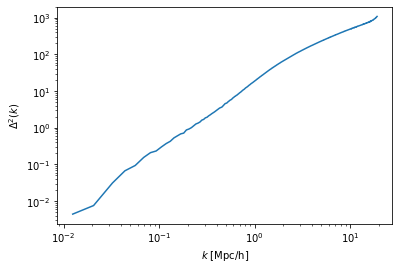

In [31]:
plt.plot(del2[0], del2[1])
plt.semilogx()
plt.semilogy()
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$\Delta^2(k)$')

In [32]:
pk = spf.fft(del2[1] / del2[0]**3 * 2 * np.pi**2)

Text(0, 0.5, '$P(k)$')

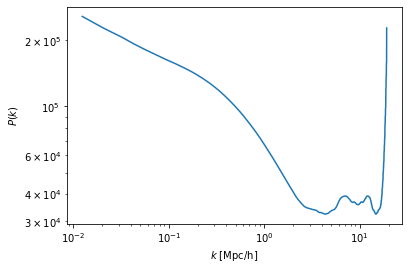

In [34]:
plt.plot(del2[0], pk.real)
plt.semilogy()
plt.semilogx()
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$')

This does not look like what I expect from the power spectrum.
Perhaps the units on $\Delta^{2}(k)$ and $k$ are not what we think they are?

## Make a kernel from the 2PCF

Note: I think this may be backwards!!!

In [6]:
kernel = np.ones((nk, nk))

In [7]:
def off_diag_indices(a, i):
    rows, cols = np.diag_indices_from(a)
    if i < 0:
        return rows[-i:], cols[:i]
    elif i > 0:
        return rows[:-i], cols[i:]
    else:
        return rows, cols

In [8]:
for i in range(1, nk):
    ind = off_diag_indices(kernel, -i)
    kernel[ind] = del2[1][-i]
    ind = off_diag_indices(kernel, i)
    kernel[ind] = del2[1][-i]

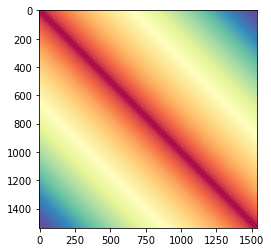

In [9]:
plt.imshow(kernel, cmap='Spectral_r')
plt.savefig('2PCFkernel.png', dpi=250)

In [10]:
# borrowed from https://gist.github.com/fasiha/fdb5cec2054e6f1c6ae35476045a0bbd
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

if __name__ == '__main__':
    import numpy as np
    for i in range(10):
        for j in range(2, 100):
            A = np.random.randn(j, j)
            B = nearestPD(A)
            assert(isPD(B))
    print('unit test passed!')


unit test passed!


In [11]:
newkern = nearestPD(kernel)

In [12]:
np.savetxt('2PCF_kernel.csv', newkern)

In [13]:
newkern = np.genfromtxt('2PCF_kernel.csv')

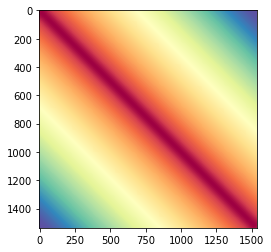

In [14]:
plt.imshow(newkern, cmap='Spectral_r')
plt.savefig('posdef2PCFkernel.png', dpi=250)

## Compare samples from this kernel with the original 2PCF

The kernel was sampled using Rafael de Souza's `R` code.

In [15]:
randfield = np.genfromtxt('RF_fromKernel.dat')

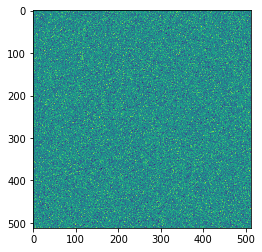

In [16]:
plt.imshow(randfield)

In [19]:
ftrand = np.fft.ifft(randfield)

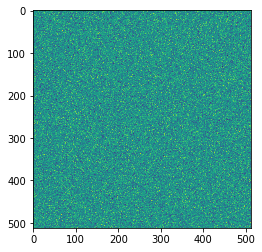

In [21]:
plt.imshow(np.real(ftrand))

In [22]:
samps = np.genfromtxt('RF_fromKernel.csv')

In [23]:
samps.shape

(512, 512)

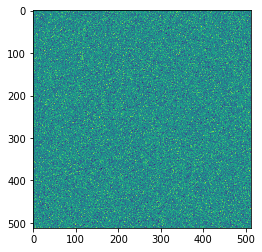

In [24]:
plt.imshow(samps)

Something has gone very wrong here. . .

## From first principles

Alberto Krone-Martins points out that this is outlined in [Rocha+05](https://academic.oup.com/mnras/article/357/1/1/1033689).

In [35]:
whitenoise = np.random.random((len(pk), len(pk)))

In [36]:
fftwn = spf.fft(whitenoise)

In [37]:
fftwn.real = del2[1] * np.eye(len(pk))

In [38]:
ifftwn = spf.ifft(fftwn)

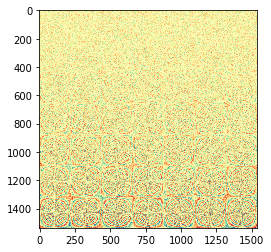

In [39]:
plt.imshow(ifftwn.real, cmap='Spectral_r')

Something has again gone wrong. . .

## From first principles, part 2

I think the non-Python code below from Joachim Harnois-Deraps does almost the same thing as [Rocha+05](https://academic.oup.com/mnras/article/357/1/1/1033689).

In [ ]:
# !! The code is to generate a Gaussian stochastic field with a given 3d power spectrum
# !! written by T.T.Lu on Oct 13, 2006
# !! compile with 'efc GaussRandomField.f90 -L/opt/fftw-3.1.2_intel8/lib/ -lfftw3f -I/opt/fftw-3.1.2_intel8/include/ -o GaussRandomField.x'
# !! replace the fftw library by the corresponding one on the machine used

# Subroutine GaussRandomField_3d_r2c(den, box, nc, kg, delta2, nk)
#   implicit none

#   !! nc is the number of grids on each dimension
#   !! nt is the number of threads for openmp
#   !! nk is the number of points at the input power spectrum table
#   !! box is the physical size of the box
#   integer nc,nk
#   integer, parameter :: nt=1

#   real, dimension(nc+2,nc,nc) :: den
#   real, dimension(nk) :: pk,kg,delta2
# !  real, dimension(0:nk) :: factor
#   real, dimension(0:nc) :: factor
#   real, dimension(nc,nc,nc) :: x1,x2
#   real box

#   integer hc,it,i,j,k,k1,k2,kx,ky,kz,kpt
#   real pi,kr,w1,w2

#   external sfft3_r2c

#   write(*,*)'Called GaussRandomField_3d_r2c'


#   pi=acos(-1.)
#   hc=nc/2

#   do i=1,nk
#      pk(i)=delta2(i)/kg(i)**3*2*pi**2
#   enddo


#   !! generate whitenoise source
#   call random_number(x1(:,:,:))
#   call random_number(x2(:,:,:))

#   den=0
#   do k=1,nc
#      do j=1,nc
#         do i=1,nc
#            den(i,j,k)=sqrt(-2*log(x1(i,j,k)))*cos(2*pi*x2(i,j,k))
#         enddo
#      enddo
#   enddo
#   !write(*,*) 'step3'

#   call sfft3_r2c(den,nc,1)
#   !write(*,*) 'called  fft forward'

#   !write(*,*) '1 :Max = ' , maxval(den), 'min = ', minval(den)


#   factor=0
#   do k=1,nk
#      factor(k)=pk(k)/(box**3/nc**3)
#   enddo

#   kpt=nc/nt
#   !!$omp parallel do default(shared) &
#   !!$omp& private(it,i,j,k,kr,kri,kx,ky,kz,k1,k2,w1,w2,tmp)
#   do it=1,nt
#      do k=1+(it-1)*kpt,min(nc,it*kpt)
#         if (k .le. hc+1) then
#             kz=k-1
#         else
#             kz=k-1-nc
#         endif
#         do j=1,nc
#             if (j .le. hc+1) then
#                 ky=j-1
#             else
#                 ky=j-1-nc
#             endif
#             do i=1,nc+2,2
#                kx=(i-1)/2
#                kr=sqrt(kx**2.+ky**2+kz**2)
#                if(kr.ne.0) then
#                  k1=ceiling(kr)
#                  k2=k1+1
#                  w1=k1-kr
#                  w2=1-w1
#                  den(i,j,k)=den(i,j,k)*sqrt(factor(k1-1)*w1+factor(k2-1)*w2) !! interpolation causes problem
#                  den(i+1,j,k)=den(i+1,j,k)*sqrt(factor(k1-1)*w1+factor(k2-1)*w2)
#                else
#                  den(i,j,k)=den(i,j,k)*sqrt(factor(0))
#                  den(i+1,j,k)=den(i+1,j,k)*sqrt(factor(0))
#                endif
#            enddo
#         enddo
#      enddo
#   enddo
#   !!$omp end parallel do

# !  write(*,*) '2 :Max = ' , maxval(den), 'min = ', minval(den)
#   call sfft3_r2c(den,nc,-1)
# !  write(*,*) '3 :Max = ' , maxval(den), 'min = ', minval(den)

# !  write(*,*) 'called  fft backward'

#   return
# end subroutine GaussRandomField_3d_r2c

In [41]:
randopk = pk
randopk.imag = whitenoise[0]

In [78]:
newdel2rev = spf.ifft(randopk)
newdel2 = np.flip(newdel2rev.real)

In [79]:
newdel2

array([ 8557.61552886,  9001.28926255,  7866.97713886, ...,
        9001.2954288 ,  8557.63814433, 45172.52228988])

Text(0, 0.5, '$\\Delta^2(k)$')

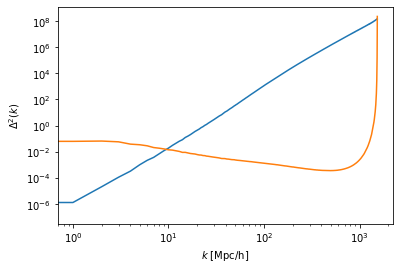

In [86]:
plt.plot((del2[0]**3 * 2 * np.pi**2) * del2[1])
plt.plot(newdel2 / (del2[0]**3 * 2 * np.pi**2))
plt.semilogx()
plt.semilogy()
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$\Delta^2(k)$')

This also isn't returning quitewhat I expect, so 

In [ ]:
phase = np.sqrt(-2 * np.log(whitenoise1)) * np.cos(2 * np.pi * whitenoise2)

In [ ]:
plt.plot(2 * np.pi / del2[0], pk.real)
plt.semilogy()
plt.semilogx()

In [ ]:
help(type(pkft[0]))

# scratch after here

In [ ]:
nc = samps.shape[0]                # define how many cells your box has
boxlen = 50.0           # define length of box
Lambda = boxlen/4.0     # define an arbitrary wave length of a plane wave
dx = boxlen/nc          # get size of a cell

    # create plane wave density field
density_field = samps#np.zeros((nc, nc, nc), dtype='float')
for x in range(density_field.shape[0]):
    density_field[x,:] = np.cos(2*np.pi*x*dx/Lambda)

In [ ]:
    # get overdensity field
delta = density_field/np.mean(density_field) - 1

In [ ]:
    # get P(k) field: explot fft of data that is only real, not complex
delta_k = np.abs(np.fft.rfftn(delta).round())
Pk_field =  delta_k**2

In [ ]:
    # get 3d array of index integer distances to k = (0, 0, 0)
dist = np.minimum(np.arange(nc), np.arange(nc,0,-1))
dist_z = np.arange(nc//2+1)
dist *= dist
dist_z *= dist_z
dist_3d = np.sqrt(dist[:, None, None] + dist[:, None] + dist_z)

In [ ]:
    # get unique distances and index which any distance stored in dist_3d 
    # will have in "distances" array
distances, _ = np.unique(dist_3d, return_inverse=True)

    # average P(kx, ky, kz) to P(|k|)
Pk = np.bincount(_, weights=Pk_field.ravel())/np.bincount(_)

    # compute "phyical" values of k
dk = 2*np.pi/boxlen
k = distances*dk

    # plot results
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(k, Pk, label=r'$P(\mathbf{k})$')

In [ ]:
img = samps

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()          

In [ ]:
def compute_results(array, Nbins=20):
#     print(np.shape(array))
#     np.random.seed(rseed)
    bins = 10. ** np.linspace(np.log10(1. / 50000.), np.log10(10.), Nbins)
#     results = [bins]
    print(np.shape(bins))
    results = two_point(array, bins)
    print(np.shape(corr))
#         (array['Ra'],
#                                            array['Dec'],
#                                            bins=bins,
#                                            method=method,
#                                            Nbootstraps=Nbootstraps)
    return (bins, results)
#

In [ ]:
(bins, corr) = compute_results(samps)

In [ ]:
bins

In [ ]:
corr

In [ ]:
plt.plot(bins, corr)

In [ ]:
bin_centers = 0.5 * (bins[1:] + bins[:-1])
#
bin_centers = bin_centers[np.where(np.isnan(corr)==False)]
corr = corr[np.where(np.isnan(corr)==False)]
corr_err = corr_err[np.where(np.isnan(corr)==False)]
#
# Export the TPCF data to an numpy array
tpcf = np.transpose(np.array([bin_centers, corr, corr_err]))
#
# Print the TPCF file
# print(tpcf)
#
# Export the TPCF data to a file
# np.savetxt('./Data/ngc1566_astroml_tpcf.dat', tpcf)
#
# Import fitting process
from scipy.optimize import curve_fit
#
# Define the fitting function
def fitfunc(x, a, b, c):
    return a*(x/b)**c
#
# Plot the Landy-Szalay TPCF and its fit
popt, pcov = curve_fit(fitfunc, bin_centers[1:10], corr[1:10])
#

still working on this. . . 